<a href="https://colab.research.google.com/github/rohithn6736/Employee-Retention/blob/main/Employee_Retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Employee Retention Dataset
The dataset contains 14249 observations with 10 features with each observation representing an employee.

#Problem
This is a binary classification problem, the aim is to predict if a employee leave or stay based on the given features.

#Metrics Used
*   Confusion Matrix
*   ROC-AUC





##Import libraries

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import pickle as pkl

In [5]:
np.set_printoptions(precision = 2,suppress=True)
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/Employee_Retention/employee_data.csv')
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [6]:
df.shape

(14249, 10)

In [7]:
df.columns

Index(['avg_monthly_hrs', 'department', 'filed_complaint', 'last_evaluation',
       'n_projects', 'recently_promoted', 'salary', 'satisfaction', 'status',
       'tenure'],
      dtype='object')

In [8]:
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


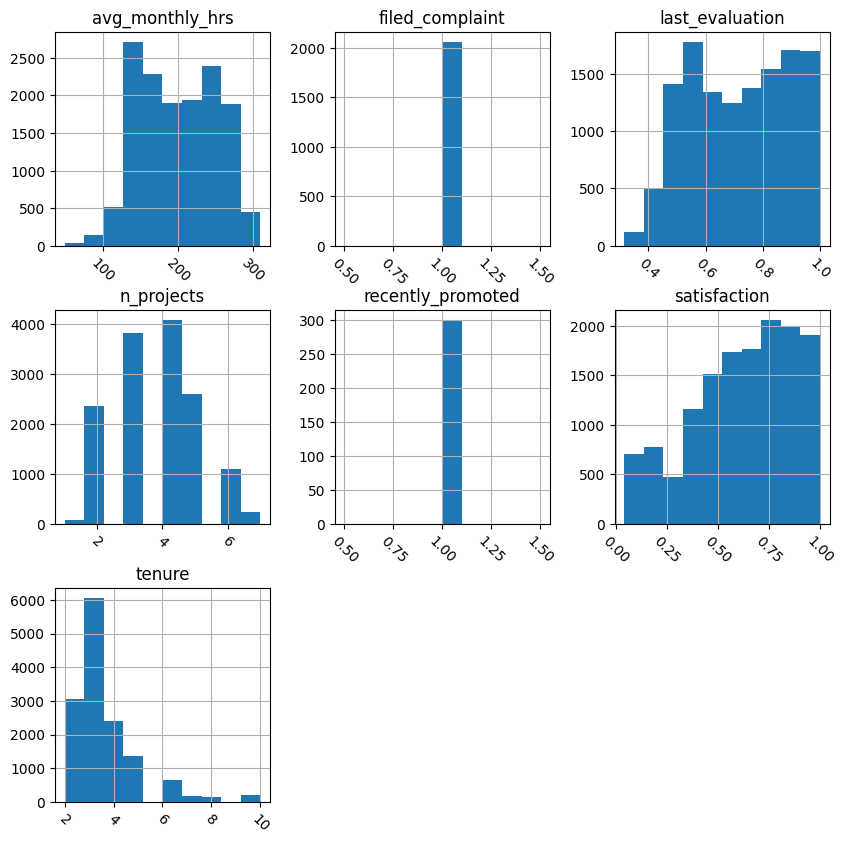

In [10]:
df.hist(figsize=(10,10), xrot=-45)  #Numerical Features Distribution
plt.show()

##Observations
* 'filed_complaint and 'recently_promomoted' must be binary indicator variables.
*  Most of the employees have 'tenure' less than or equal to 5 years.




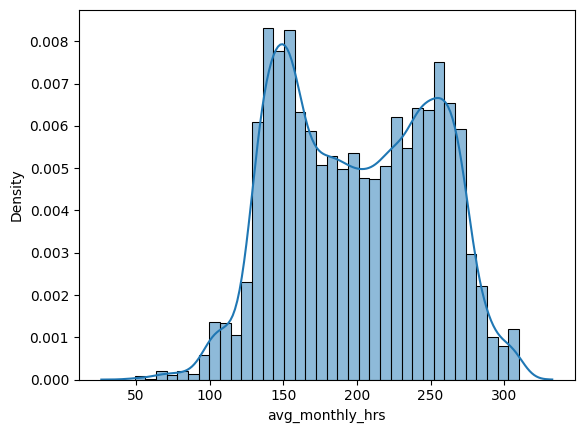

In [11]:
plt.figsize = (5,5)
sns.histplot(df['avg_monthly_hrs'], kde = True, stat='density',kde_kws={'cut':3})
plt.show()

##Observations
*   Close to 50% of the employees work for 200 hours a month on an average.



##Distribution of categorical features

In [12]:
df.describe(include=['O'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


In [13]:
df['department'].value_counts()

sales                     3923
engineering               2592
support                   2122
IT                        1161
product                    860
marketing                  819
finance                    728
management                 595
information_technology     209
temp                       181
admin                      176
procurement                174
Name: department, dtype: int64

Employees belonging to 'temp' department don't belong to any department, so they can be removed.

In [14]:
df['salary'].value_counts()

low       6952
medium    6146
high      1151
Name: salary, dtype: int64

In [15]:
df['status'].value_counts()

Employed    10857
Left         3392
Name: status, dtype: int64

The dataset is not balanced as almost 24% of employees have left.


<Axes: xlabel='count', ylabel='department'>

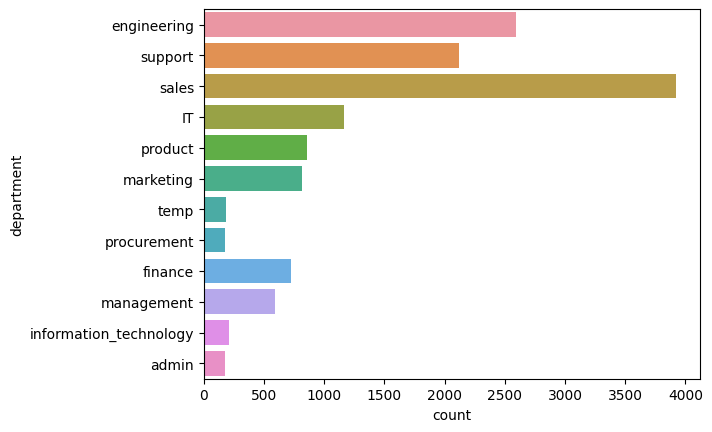

In [16]:
sns.countplot(y = df['department'])

<Axes: xlabel='satisfaction', ylabel='status'>

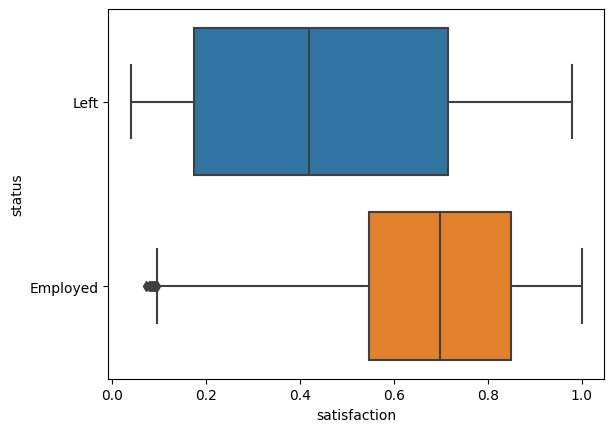

In [17]:
sns.boxplot(x='satisfaction',y='status',data=df) # Status vs satisfaction

##Observation
Employees who left had less satisfaction.

<Axes: xlabel='last_evaluation', ylabel='status'>

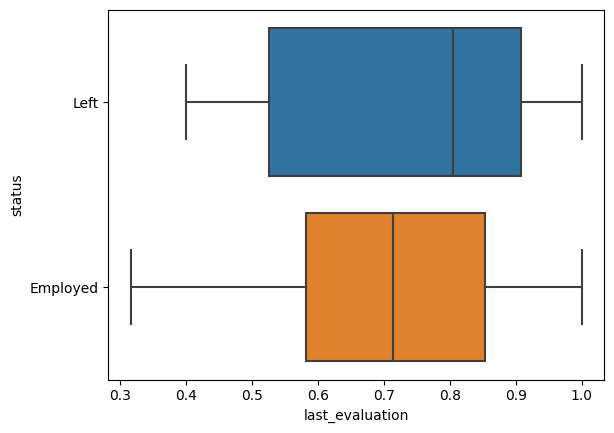

In [18]:
sns.boxplot(x='last_evaluation',y='status',data=df) # Status vs last_evaluation

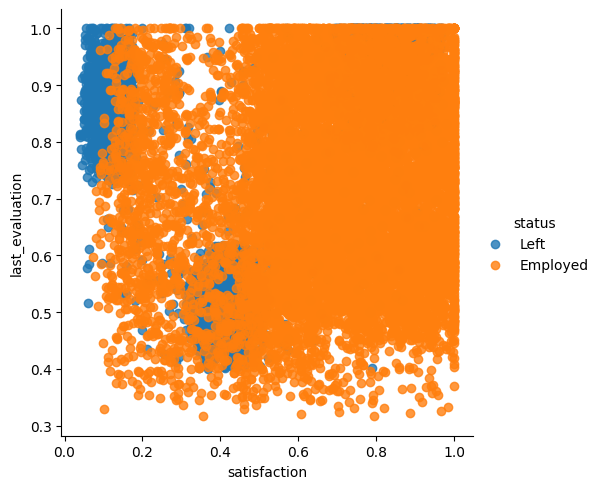

In [19]:
sns.lmplot(x='satisfaction',y='last_evaluation', hue='status', data=df, fit_reg=False) # 'last_evaluation' vs 'satisfaction'

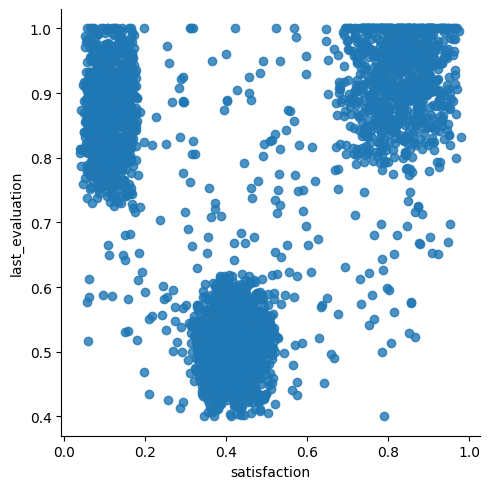

In [20]:
# 'last_evaluation' vs 'satisfaction' showing employees who left
sns.lmplot(y='last_evaluation',x='satisfaction',data=df[df.status=='Left'], fit_reg=False)

We see 3 clusters and we can try to group them as follows:
* satisfaction < 0.2 (we can name them as 'Unhappy')
* last_evaluation < 0.6 (we can name them as 'Underperformers')
* satisfaction > 0.7 and last_evaluation > 0.8 (We can name them as 'Overachievers')

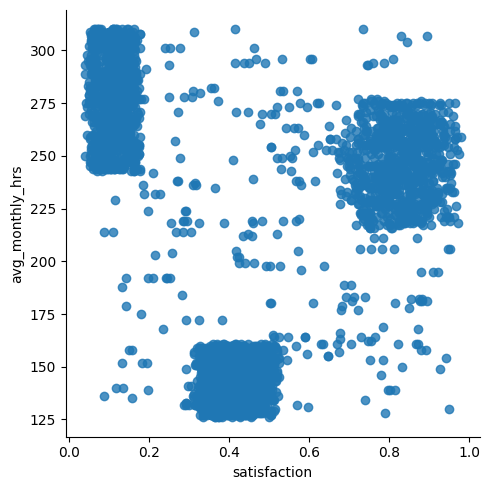

In [21]:
# 'avg_monthly_hrs' vs 'satisfaction' showing employees who left
sns.lmplot(x='satisfaction',y='avg_monthly_hrs',data=df[df['status'] == 'Left'],fit_reg = False)

We notice similar 3 clusters here as well.
* The left cluster (unhappy) -> putting a lot of effort and still not satisfied.
* The middle cluster (underperformer) -> not putting much effort.
* The right cluster (overachievers) -> putting more effort as well as satisfied

#Correlations

<Axes: >

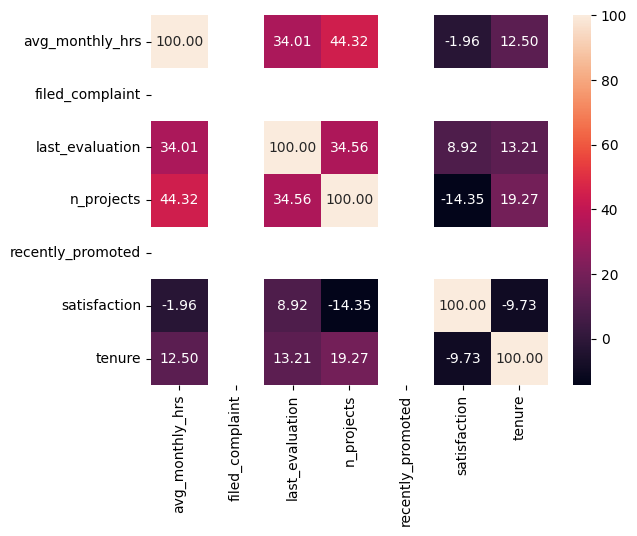

In [22]:
sns.heatmap(df.corr()*100,annot=True,fmt='.2f')

# Data Cleaning

In [23]:
print(df.shape)

(14249, 10)


In [24]:
# Removing duplicates
df = df.drop_duplicates()
print(df.shape)

(14221, 10)


In [25]:
# Removing employees belonging to temporary department
df = df[df.department != 'temp']
df

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0
...,...,...,...,...,...,...,...,...,...,...
14244,178,IT,NaN,0.735865,5,NaN,low,0.263282,Employed,5.0
14245,257,sales,NaN,0.638604,3,NaN,low,0.868209,Employed,2.0
14246,232,finance,1.0,0.847623,5,NaN,medium,0.898917,Left,5.0
14247,130,IT,NaN,0.757184,4,NaN,medium,0.641304,Employed,3.0


#Fix Structural errors

In [26]:
# Print unique values of 'filed_complaint'
print( df.filed_complaint.unique() )

# Print unique values of 'recently_promoted'
print( df.recently_promoted.unique() )

[nan  1.]
[nan  1.]


The nan values for 'filed_complaint' indicate employees who haven't filed complaints which can be replaced with zeroes.

Similarly, the nan values for 'recently_promoted' inddicates employees who were not promoted recently.

In [27]:
df['filed_complaint'] = df.filed_complaint.fillna(0)
df['recently_promoted'] = df.recently_promoted.fillna(0)

In [28]:
print(df.filed_complaint.unique())
print(df.recently_promoted.unique())

[0. 1.]
[0. 1.]


#Typos and Capitalization

<Axes: xlabel='count', ylabel='department'>

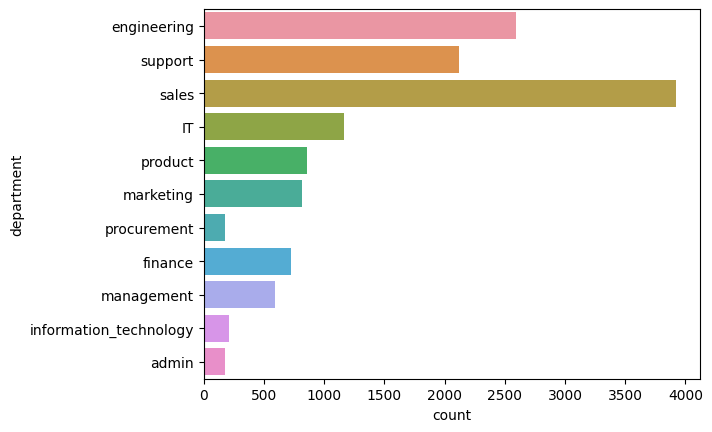

In [29]:
sns.countplot(y='department', data=df)

Here, information_technology can be replaced with IT.

<Axes: xlabel='count', ylabel='department'>

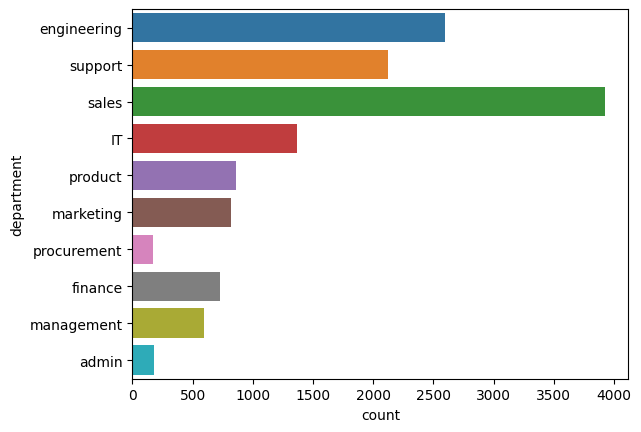

In [30]:
df.department.replace('information_technology','IT',inplace=True)
sns.countplot(y='department', data=df)

# Missing data

In [31]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

'department' and 'last_evaluation' have missing data.

In [32]:
# Replacing null values in department with 'Missing'
df['department'] = df.department.fillna('Missing')

In [33]:
# Creating an indicator variable to indicate missing 'last_evaluation'
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

In [34]:
# Replacing the null values in 'last_evaluation' with 0.
df.last_evaluation.fillna(0,inplace = True)

In [35]:
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

# Feature Engineering

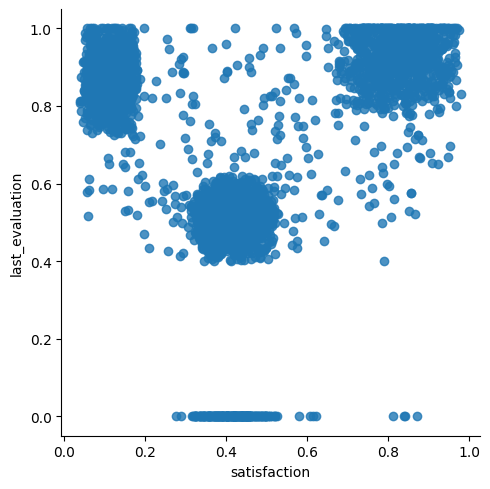

In [36]:
sns.lmplot(x = 'satisfaction', y='last_evaluation', data = df[df.status == 'Left'], fit_reg = False)

Creating 3 indicator variables for 'underperformer', 'unhappy' and 'overacheivers' based on the scatterplot of 'satisfaction' and 'last_evaluation' for employees who have 'Left'.

In [37]:
df['underperformer'] = ((df.last_evaluation <0.6) &
                        (df.last_evaluation_missing == 0)).astype(int)
df['unhappy'] = (df.satisfaction < 0.2).astype(int)
df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

In [38]:
df[['underperformer','unhappy','overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64


* 28.5% employees are underperformning
* 9.2% employees are unhappy
* 17.7% employees are overachievers




Indicator variable for status: 1 for 'Left' and 0 for 'Employed'

In [39]:
df['status'] = pd.get_dummies(df.status).Left

In [40]:
df.status.mean()

0.23933750355416547

23.9% employees have left

# One hot encoding for categorical variables

In [41]:
df = pd.get_dummies(df, columns = ['department','salary'])
df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [42]:
df.to_csv('Retention_analytical_base_table', index = None)

# Machine Learning Models

In [43]:
df = pd.read_csv('Retention_analytical_base_table')
df.shape

(14068, 26)

## Train Test split

In [44]:
y = df.status
X = df.drop('status', axis = 1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify = df.status)

In [46]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11254, 25) (2814, 25) (11254,) (2814,)


# Data Standardization

In [47]:
train_mean = X_train.mean()
train_std = X_train.std()

In [59]:
np.array(train_std)

array([49.86,  0.35,  0.27,  1.23,  0.14,  0.25,  1.46,  0.3 ,  0.45,
        0.29,  0.38,  0.29,  0.22,  0.11,  0.39,  0.22,  0.21,  0.23,
        0.11,  0.24,  0.45,  0.36,  0.27,  0.5 ,  0.5 ])

In [48]:
X_train = (X_train - train_mean)/train_std


In [49]:
X_train.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
count,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04,1.125400e+04
mean,-1.104896e-16,6.566238e-17,-3.535667e-16,1.610780e-16,4.230173e-17,-2.051949e-16,-5.429774e-17,7.071333e-17,2.020381e-17,-7.450155e-17,5.429774e-17,-9.344262e-17,3.409393e-17,2.462339e-17,-9.896710e-17,1.010190e-17,-4.545857e-17,3.661941e-17,1.333767e-17,-3.314688e-17,5.682322e-18,1.041759e-16,4.829973e-17,-1.894107e-18,-9.880926e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.097551e+00,-4.066418e-01,-2.417939e+00,-1.455347e+00,-1.457128e-01,-2.327064e+00,-1.024920e+00,-3.267968e-01,-6.344341e-01,-3.151772e-01,-4.631725e-01,-3.252960e-01,-2.316072e-01,-1.080991e-01,-4.775417e-01,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,-6.223287e-01,-4.182927e-01,-2.983599e-01,-9.767671e-01,-8.684807e-01
25%,-9.142094e-01,-4.066418e-01,-4.586632e-01,-6.436473e-01,-1.457128e-01,-6.841787e-01,-3.396507e-01,-3.267968e-01,-6.344341e-01,-3.151772e-01,-4.631725e-01,-3.252960e-01,-2.316072e-01,-1.080991e-01,-4.775417e-01,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,-6.223287e-01,-4.182927e-01,-2.983599e-01,-9.767671e-01,-8.684807e-01
50%,-3.171743e-02,-4.066418e-01,1.388747e-01,1.680522e-01,-1.457128e-01,1.210881e-01,-3.396507e-01,-3.267968e-01,-6.344341e-01,-3.151772e-01,-4.631725e-01,-3.252960e-01,-2.316072e-01,-1.080991e-01,-4.775417e-01,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,-6.223287e-01,-4.182927e-01,-2.983599e-01,-9.767671e-01,-8.684807e-01
75%,8.908879e-01,-4.066418e-01,7.816106e-01,9.797517e-01,-1.457128e-01,8.126088e-01,3.456181e-01,-3.267968e-01,1.576068e+00,-3.151772e-01,-4.631725e-01,-3.252960e-01,-2.316072e-01,-1.080991e-01,-4.775417e-01,-2.366739e-01,-2.160667e-01,-2.467631e-01,-1.110062e-01,-2.543731e-01,1.606725e+00,-4.182927e-01,-2.983599e-01,1.023695e+00,1.151334e+00
max,2.194569e+00,2.458948e+00,1.311132e+00,2.603151e+00,6.862203e+00,1.518713e+00,4.457231e+00,3.059733e+00,1.576068e+00,3.172536e+00,2.158831e+00,3.073850e+00,4.317271e+00,9.249953e+00,2.093872e+00,4.224847e+00,4.627788e+00,4.052110e+00,9.007706e+00,3.930883e+00,1.606725e+00,2.390458e+00,3.351360e+00,1.023695e+00,1.151334e+00


In [50]:
X_test = (X_test - train_mean)/train_std

In [51]:
X_test.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
count,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000
mean,0.050369,0.029205,0.020064,0.032769,0.018652,0.007616,0.005419,-0.007881,-0.019358,0.031859,0.005508,0.028631,-0.011761,0.044875,-0.018818,-0.028977,-0.055982,0.017524,0.008892,0.007391,-0.003675,0.026875,-0.010429,0.001426,0.004332
std,1.009275,1.029258,0.999263,1.016184,1.060773,1.017268,1.005757,0.989272,0.990786,1.044182,1.004778,1.038349,0.975736,1.186863,0.984625,0.940117,0.866064,1.032797,1.038904,1.013605,0.998316,1.025946,0.984026,1.000166,1.000736
min,-2.077494,-0.406642,-2.417939,-1.455347,-0.145713,-2.326534,-1.024920,-0.326797,-0.634434,-0.315177,-0.463172,-0.325296,-0.231607,-0.108099,-0.477542,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,-0.622329,-0.418293,-0.298360,-0.976767,-0.868481
25%,-0.854040,-0.406642,-0.447861,-0.643647,-0.145713,-0.671221,-0.339651,-0.326797,-0.634434,-0.315177,-0.463172,-0.325296,-0.231607,-0.108099,-0.477542,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,-0.622329,-0.418293,-0.298360,-0.976767,-0.868481
50%,0.048509,-0.406642,0.195125,0.168052,-0.145713,0.149043,-0.339651,-0.326797,-0.634434,-0.315177,-0.463172,-0.325296,-0.231607,-0.108099,-0.477542,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,-0.622329,-0.418293,-0.298360,-0.976767,-0.868481
75%,0.925987,-0.406642,0.785055,0.979752,-0.145713,0.834208,0.345618,-0.326797,1.576068,-0.315177,-0.463172,-0.325296,-0.231607,-0.108099,-0.477542,-0.236674,-0.216067,-0.246763,-0.111006,-0.254373,1.606725,-0.418293,-0.298360,1.023695,1.151334
max,2.194569,2.458948,1.311132,2.603151,6.862203,1.518713,4.457231,3.059733,1.576068,3.172536,2.158831,3.073850,4.317271,9.249953,2.093872,4.224847,4.627788,4.052110,9.007706,3.930883,1.606725,2.390458,3.351360,1.023695,1.151334


# Logistic Regression

In [55]:
tuned_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty':['l1','l2']}
model = GridSearchCV(LogisticRegression(), tuned_params, scoring = 'roc_auc', n_jobs = -1)
model.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [67]:
model.best_params_

{'C': 100, 'penalty': 'l2'}

In [57]:
y_train_pred = model.predict(X_train)

In [58]:
y_pred = model.predict(X_test)


In [59]:
# Get the probability for a data point to be positive class 1
y_pred_proba = model.predict_proba(X_test)[:,1]


In [60]:
y_pred_proba[:10]

array([0.03, 0.  , 0.01, 0.09, 0.07, 0.48, 0.13, 0.62, 0.73, 0.14])

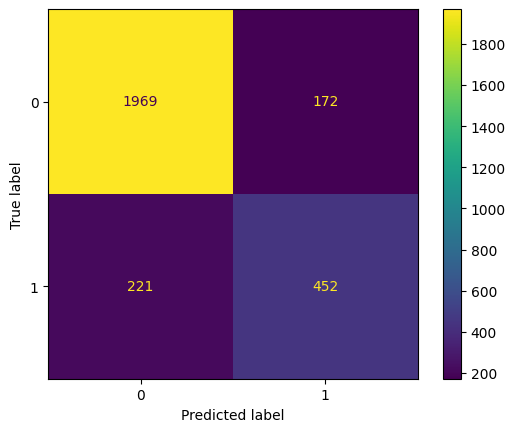

In [61]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [62]:
i=213  ## Change the value of i to get the details of any point (56, 213, etc.)
print('For test point {}, actual class = {}, precited class = {}, predicted probability = {}'.
      format(i, y_test.iloc[i], y_pred[i], y_pred_proba[i]))

For test point 213, actual class = 1, precited class = 0, predicted probability = 0.3413297649435775



* Probabilities near 0 or 1 means the model is very confident and those near 0.5 means the model is not very confident about the prediction.



In [63]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

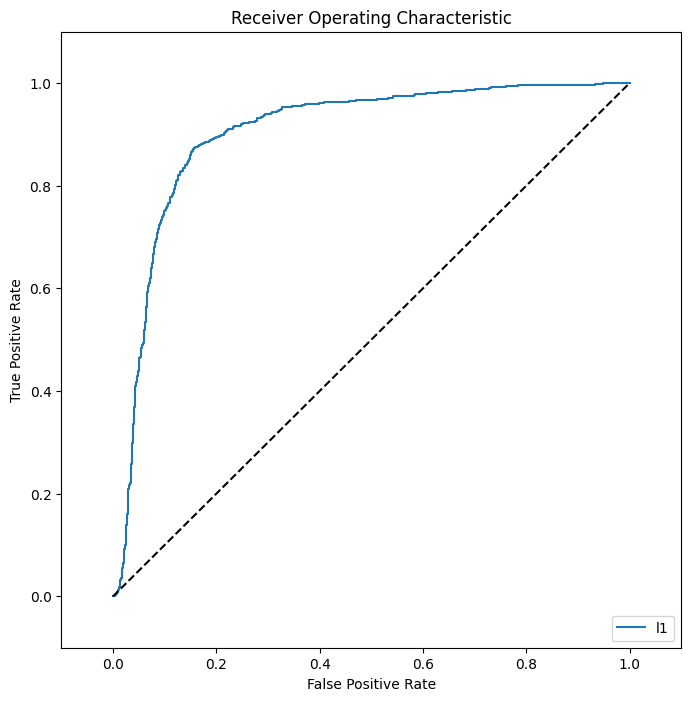

In [64]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [65]:
# Calculate AUC for Train set
print(roc_auc_score(y_train, y_train_pred))

0.7775223064060668


In [66]:
# Calculate AUC for Test set
print(auc(fpr, tpr))

0.9015374493456488


## Feature Importance

In [68]:
## Building the model again with the best hyperparameters
model = LogisticRegression(C=10, penalty = 'l2')
model.fit(X_train, y_train)

LogisticRegression(C=10)

In [69]:
indices = np.argsort(-abs(model.coef_[0,:]))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
satisfaction
overachiever
last_evaluation_missing
underperformer
last_evaluation
filed_complaint
n_projects
salary_high
tenure
avg_monthly_hrs
salary_low
recently_promoted
unhappy
department_procurement
department_management
department_Missing
department_engineering
department_admin
department_product
department_marketing
department_finance
department_IT
salary_medium
department_support
department_sales


In [72]:
# Saving the model
pkl.dump(model, open('EmpRetention_model.pkl','wb'))